In [5]:
import numpy as np
from copy import copy
from typing import Mapping
from typing import Callable
from matplotlib import pyplot as plt
from matplotlib import cm
from celluloid import Camera

In [6]:
def test_function_1(x: np.ndarray) -> float:
    '''
    Функция Бута
    '''
    return (x[0] + 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2

In [7]:
def test_function_2(x: np.ndarray) -> float:
    '''
    Функция Розенброка
    '''
    return 100 * (x[1] - x[0] ** 2) ** 2 + (x[0] - 1) ** 2

In [8]:
def tf1_draw(x, y):
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

In [9]:
def tf2_draw(x, y):
    return 100 * (y - x ** 2) ** 2 + (x - 1) ** 2

In [10]:
BoothFunction: Mapping[str, Callable] = {
    'request'  : test_function_1,
    'draw'     : tf1_draw,
    'solution' : lambda: np.array([1, 3])
}

RosenbrokFunction: Mapping[str, Callable] = {
    'request'  : test_function_2,
    'draw'     : tf2_draw,
    'solution' : lambda: np.array([1, 1])
}

In [11]:
class Domain:
    
    def __init__(self, left_border: np.ndarray, right_border: np.ndarray):
        self.__lb = left_border
        self.__rb = right_border
        
    def is_in_domain(self, x: np.ndarray) -> bool:
        statement_1 = x >= self.__lb
        statement_2 = x <= self.__rb
        
        return statement_1.all() and statement_2.all()

    def get_left_bounds(self):
        return self.__lb

    def get_right_bounds(self):
        return self.__rb

In [12]:
class Plot:
    def __init__(self, 
                 function: Mapping[str, Callable], 
                 domain: Domain):
        self.__function   = function
        self.__domain     = domain

    def render(self):
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        lb = self.__domain.get_left_bounds()
        rb = self.__domain.get_right_bounds()
        x = np.linspace(lb[0], rb[0])
        y = np.linspace(lb[1], rb[1])
        xg, yg = np.meshgrid(x, y)
        z = self.__function['draw'](xg, yg)
        surf = ax.plot_surface(xg, yg, z, cmap = cm.plasma, linewidth = 0, antialiased = False)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()

In [13]:
p = Plot(BoothFunction, domain)
p.render()

NameError: name 'domain' is not defined

In [14]:
p = Plot(RosenbrokFunction, domain)
p.render()

NameError: name 'domain' is not defined

In [15]:
class FirstOrderOracle():
    
    def __init__(self, function: Mapping[str, Callable], domain: Domain):
        self.__func   = function
        self.__domain = domain
    
    def query(self, x: np.ndarray, step: float = 1e-9) -> (float, np.ndarray):
        fn: float  = np.inf
        drv: np.ndarray = np.zeros(len(x))
            
        if self.__domain.is_in_domain(x):
            fn: float = (self.__func['request'])(x)
            
            for i in range(len(x)):
                delta = np.zeros(len(x))
                delta[i] = step
                drv[i] = (self.__func['request'](x + delta) - fn) / step

        return fn, drv

    def solution(self):
        return self.__func['solution'](), self.__func['request'](self.__func['solution']())

In [16]:
class GradientDescent():
    
    def __init__(self, 
                 oracle,
                 initial_point: np.ndarray, 
                 learning_rate: float = 1e-3,
                 accuracy: float = 1e-3,
                 max_iter: int   = 1e+3):
        self.__oracle        = oracle
        self.__init_point    = initial_point
        self.__lr            = learning_rate
        self.__acc           = accuracy
        self.__max_iter      = max_iter
        self.__found_p       = np.zeros(len(initial_point))
        self.__fount_fn      = 0.0
    
    def step(self, current_point: np.ndarray) -> np.ndarray:
        _, drv = self.__oracle.query(current_point)
        next_point = current_point - self.__lr * drv
        return next_point
        
    def solve(self):
        traj = []
        prev_point = copy(self.__init_point)
        next_point = self.step(prev_point)
        counter = 0
        
        traj.append(self.__init_point)
        traj.append(next_point)
        while np.linalg.norm(prev_point - next_point) >= self.__acc and counter < self.__max_iter:
            prev_point = next_point
            next_point = self.step(prev_point)
            traj.append(next_point)
            counter += 1
            
        self.__found_p  = next_point
        self.__found_fn = self.__oracle.query(next_point)[0]
        self.__trajectory = np.array(traj)
    
    def get_numeric_solution(self):
        return self.__found_p, self.__found_fn

    def get_true_solution(self):
        return self.__oracle.solution()

    def get_trajectory(self):
        return self.__trajectory

In [17]:
class MomentumGradientDescent():
    
    def __init__(self, 
                 oracle,
                 initial_point: np.ndarray, 
                 learning_rate: float = 1e-3,
                 accuracy: float = 1e-3,
                 max_iter: int   = 1e+3):
        self.__oracle        = oracle
        self.__init_point    = initial_point
        self.__lr            = learning_rate
        self.__acc           = accuracy
        self.__max_iter      = max_iter
        self.__beta          = np.random.uniform(-0.25, 0.25)
        self.__direction     = 0.0
        
    def step(self, current_point: np.ndarray) -> np.ndarray:
        _, drv = self.__oracle.query(current_point)
        self.__direction = self.__beta * self.__direction - self.__lr * drv
        next_point = current_point + self.__direction
        return next_point
        
    def solve(self):
        traj = []
        prev_point = copy(self.__init_point)
        next_point = self.step(prev_point)
        counter = 0
        
        traj.append(self.__init_point)
        traj.append(next_point)
        while np.linalg.norm(prev_point - next_point) >= self.__acc and counter < self.__max_iter:
            prev_point = next_point
            next_point = self.step(prev_point)
            traj.append(next_point)
            counter += 1
            
        self.__found_p  = next_point
        self.__found_fn = self.__oracle.query(next_point)[0]
        self.__trajectory = np.array(traj)

    def get_numeric_solution(self):
        return self.__found_p, self.__found_fn

    def get_true_solution(self):
        return self.__oracle.solution()

    def get_trajectory(self):
        return self.__trajectory

In [18]:
class AdaptiveGradientDescent():
    
    def __init__(self, 
                 oracle,
                 initial_point: np.ndarray,
                 learning_rate: float = 1e-3,
                 accuracy: float = 1e-3,
                 max_iter: int   = 1e+3,
                 realibility: float = 1e-8):
        self.__oracle        = oracle
        self.__init_point    = initial_point
        self.__lr            = learning_rate
        self.__acc           = accuracy
        self.__max_iter      = max_iter
        self.__realibility   = np.ones(len(initial_point)) * realibility
        self.__G             = np.zeros(len(initial_point))
        
    def step(self, current_point: np.ndarray) -> np.ndarray:
        _, drv = self.__oracle.query(current_point)
        self.__G += drv ** 2
        next_point = current_point - self.__lr * drv / (np.sqrt(self.__G + self.__realibility))
        
        return next_point
        
    def solve(self):
        traj = []
        prev_point = copy(self.__init_point)
        next_point = self.step(prev_point)
        counter = 0
        
        traj.append(self.__init_point)
        traj.append(next_point)
        while np.linalg.norm(prev_point - next_point) >= self.__acc and counter < self.__max_iter:
            prev_point = next_point
            next_point = self.step(prev_point)
            traj.append(next_point)
            counter += 1
            
        self.__found_p  = next_point
        self.__found_fn = self.__oracle.query(next_point)[0]
        self.__trajectory = np.array(traj)

    def get_numeric_solution(self):
        return self.__found_p, self.__found_fn

    def get_true_solution(self):
        return self.__oracle.solution()
    
    def get_trajectory(self):
        return self.__trajectory

In [19]:
class Pipeline:
    
    def __init__(self, method):
        self.__method = method

    def plot_residual(self, tpoint: np.ndarray):
        trajectory = self.__method.get_trajectory()
        residual = np.zeros(len(trajectory))
        for i in range(len(trajectory)):
            residual[i] = np.linalg.norm(trajectory[i] - tpoint)

        print('Residual between numeric and true solutions is ', residual[-1])
        plt.plot(range(len(residual)), residual)
        plt.show()

    def plot_trajectory(self, tpoint: np.ndarray):
        trajectory = self.__method.get_trajectory()
        fig = plt.figure(figsize=(10,6))
        camera = Camera(fig)
        plt.title('Optimization Visualization')

        for i in range(len(trajectory)):
            plt.legend(['Solution point', 'Trajectory points'])
            plt.scatter(tpoint[0], tpoint[1], color = 'crimson', s = 100)
            plt.scatter(trajectory[i][0], trajectory[i][1], c = 'plum', edgecolors = 'lawngreen', s = 100)

            camera.snap()

        animation = camera.animate()  
        animation.save('trajectory.gif', writer = 'Pillow')

    def get_answer(self):
        point, value = self.__method.get_numeric_solution()
        tpoint, tvalue = self.__method.get_true_solution()
        print('Numeric solution was found in point ', point, ' with value ', value)
        print('True solution was found in point ', tpoint, ' with value ', tvalue)
        self.plot_residual(tpoint)
        self.plot_trajectory(tpoint)
    
    def process(self):
        self.__method.solve()
        self.get_answer()
        

In [20]:
lb = np.array([-10, -10])
rb = np.array([10, 10])

In [21]:
domain = Domain(lb, rb)

In [22]:
oracle = FirstOrderOracle(BoothFunction, domain)

In [23]:
gd = GradientDescent(oracle, np.array([0.9, 3.1]), 1e-3, 1e-9, 10000)

In [24]:
task1 = Pipeline(gd)

Numeric solution was found in point  [0.99999965 3.00000035]  with value  2.4805157718763664e-13
True solution was found in point  [1 3]  with value  0
[0.9 3.1]


MovieWriter Pillow unavailable; using Pillow instead.


KeyboardInterrupt: 

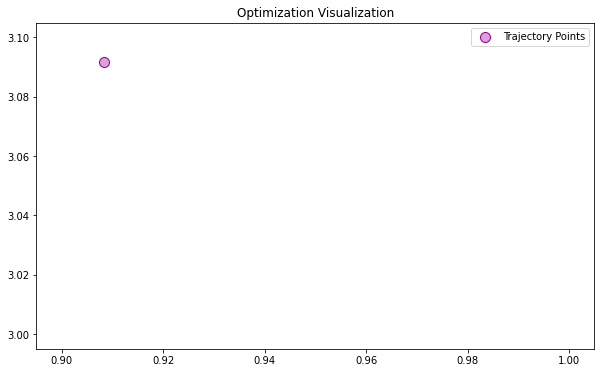

In [25]:
task1.process()